In [37]:
#Content: Make RSI function, Make Strategy execution function







#Tutorial 5 - using python to calculate RSI

#Import data from data source
import os
import pandas_datareader as pdr
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import pandas as pd

def get_ticker_df(_ticker):
    df = pdr.get_data_tiingo(_ticker, api_key='f0f2dac586726c8b6d19534c263f4874cc8b989c')
    df = df.reset_index(level=[0,1])
    df.index = df['date']
    df_adj = df.iloc[:,7:12]
    df_adj.columns = ['Close','High','Low','Open','Volume']
    return df_adj


def RSI(_src, _period):
    import pandas as pd
    Chg = _src - _src.shift(1)
    Chg_pos = pd.Series(index=Chg.index, data=Chg[Chg>0])
    Chg_pos = Chg_pos.fillna(0)
    Chg_neg = pd.Series(index=Chg.index, data=-Chg[Chg<0])
    Chg_neg = Chg_neg.fillna(0)
    import numpy as np
    up_mean = []
    down_mean = []
    for i in range(_period+1, len(Chg_pos)+1):
        up_mean.append(np.mean(Chg_pos.values[i-_period:i]))
        down_mean.append(np.mean(Chg_neg.values[i-_period:i]))
    #calculate RSI
    rsi = []
    for i in range(len(up_mean)):
        rsi.append( 100 * up_mean[i] / ( up_mean[i] + down_mean[i] ) )
    rsi_series = pd.Series(index = _src.index[_period:], data = rsi)
    return rsi_series


#MAIN
df_SPY = get_ticker_df('SPY')
SPY_Close = get_ticker_df('SPY').Close
RSI(SPY_Close,12)



date
2016-12-01 00:00:00+00:00    65.618442
2016-12-02 00:00:00+00:00    58.793908
2016-12-05 00:00:00+00:00    67.643721
2016-12-06 00:00:00+00:00    66.035433
2016-12-07 00:00:00+00:00    78.084701
                               ...    
2021-11-04 00:00:00+00:00    88.282353
2021-11-05 00:00:00+00:00    88.199052
2021-11-08 00:00:00+00:00    87.746063
2021-11-09 00:00:00+00:00    83.317757
2021-11-10 00:00:00+00:00    67.751870
Length: 1245, dtype: float64

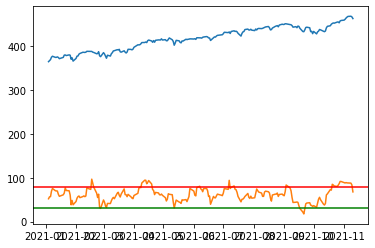

In [30]:
#plotting 
import matplotlib.pyplot as plt


Close2021 = SPY_Close['2021']
plt.plot(Close2021)
plt.plot(RSI(SPY_Close,12)['2021'])

#overbought oversold
plt.axhline(y=80, color='red')
plt.axhline(y=30, color='green')


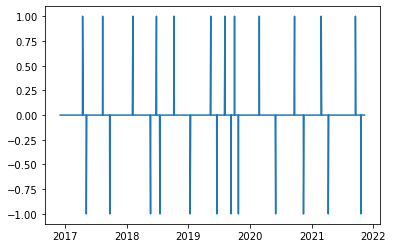

In [31]:
#trading strategies signals
#Sample strategy: RSI<30 B , RSI>80 S


#indicator 
osc = RSI(SPY_Close,12)

#trading signals

#trading signal
def RSI_Trading_Sig(_osc_src, _upper, _lower):
    import pandas as pd
    sig = []   #signal
    stock = 0  #stock (memory last action)
    # 偵測RSI訊號
    for i in range(len(_osc_src)):
        if _osc_src[i] > _upper and stock == 1:
            stock -= 1
            sig.append(-1)
        elif _osc_src[i] < _lower and stock == 0:
            stock += 1
            sig.append(1)
        else:
            sig.append(0)
    # Turn sig to be series
    rsi_sig = pd.Series(index = _osc_src.index, data = sig)
    return rsi_sig

#Learning notes: python return : python 'function' object is not subscriptable. Which means there are some 
# Variables in your lines haven't clearly defined before.
# In most cases you're typing a wrong variable name in your function.

rsi_sig = RSI_Trading_Sig(RSI(SPY_Close,12),80,30)
plt.plot(rsi_sig)

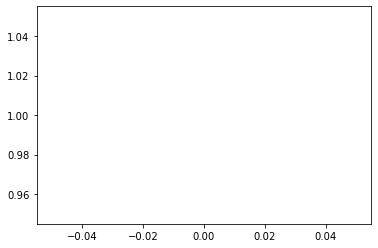

In [32]:
#Strategy
SPY_Open = get_ticker_df('SPY').Open



def strategy(_price_src, _signal_src):
    stock = 0
    buy_price = 0
    sell_price = 0
    rets = []
    for i in range(len(_signal_src)):
        if _signal_src[i] == 1:
            # Take action after bar close
            buy_price = _price_src[_signal_src.index[i+1]]
            stock += 1
        elif _signal_src[i] == -1:
            # Take action after bar close
            sell_price = _price_src[_signal_src.index[i+1]]
            stock -= 1
            rets.append((sell_price-buy_price)/buy_price)
            # Clear up memory after all position closed
            buy_price = 0
            sell_price = 0
    #Selling, for the last day of the backtesing (already gone through the for loop run)
    if stock == 1 and buy_price != 0 and sell_price == 0:
        sell_price = _price_src[-1]
        rets.append((sell_price-buy_price)/buy_price)
    total_ret = 1
    for ret in rets:
        total_ret *= 1 + ret
    return total_ret
        
        
#print out 
total_ret = strategy(SPY_Open,RSI(SPY_Close,12))

##print(str(round((total_ret - 1)*100,2)) + '%')
import matplotlib.pyplot as plt
plt.plot(total_ret)



Total return：157.25%
Parameter：RSI lookback period: 24 ,Upper bond: 89 ,Lower bond: 30


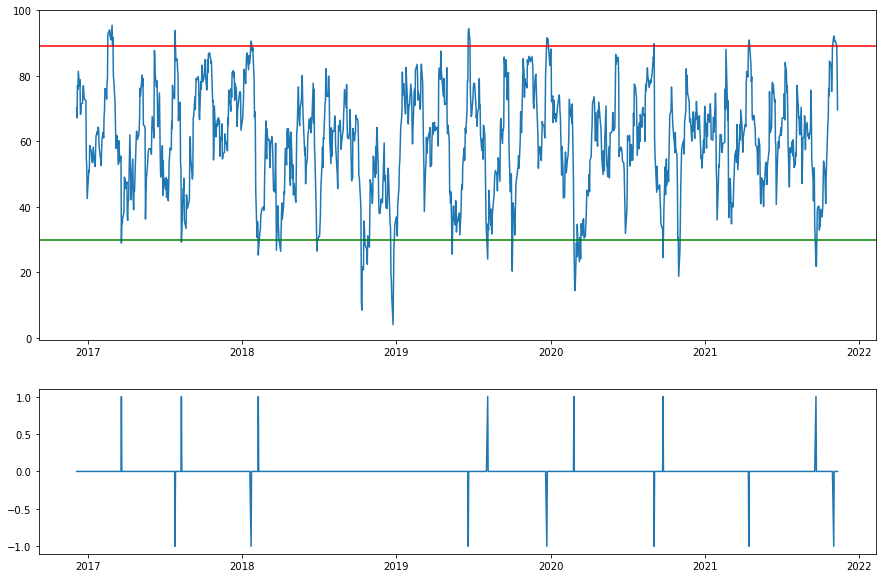

In [35]:
#maximizing (total return) by tuning (period, upper, lower)

max_total_ret, max_period, max_upper, max_lower = 0, 0, 0, 0

# Hyperparameter optimization

#Learning notes: make sure there is one output in your "Backtest" function. 
#It's better to make it only one output, i.e. "total final PnL"


max_total_ret, max_period, max_upper, max_lower = 0, 0, 0, 0
for period in range(6,25):
    for upper in range(70,91):
        for lower in range(10,31):
            ret = strategy(SPY_Open,RSI_Trading_Sig(RSI(SPY_Close, period), upper, lower))
            if ret > max_total_ret:
                max_total_ret, max_period, max_upper, max_lower = ret, period, upper, lower

                
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib import gridspec

x = RSI(SPY_Close, max_period).index
y = RSI(SPY_Close, max_period).values

fig = plt.figure(figsize=(15,10))
# set height ratios for sublots
gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1]) 

# the fisrt subplot
ax0 = plt.subplot(gs[0])
# line0 = ax0.plot(x, y, color='r')
ax0.plot(RSI(SPY_Close, max_period))
ax0.axhline(y=max_upper, color='red')
ax0.axhline(y=max_lower, color='green')



#the second subplot
# shared axis X
ax1 = plt.subplot(gs[1], sharex = ax0)
rsi_sig = pd.Series(index = RSI(SPY_Close, max_period).index, data = list(RSI_Trading_Sig(RSI(SPY_Close, max_period), max_upper, max_lower).values))
ax1.plot(rsi_sig)

print('Total return：' + str(round(100*(max_total_ret-1),2)) + '%')
print('Parameter：' + 'RSI lookback period: ' + str(period) + ' ,Upper bond: ' + str(max_upper) + ' ,Lower bond: ' + str(max_lower))
plt.show()